In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Operationalizing TimesFM on Vertex AI

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.sandbox.google.com/github/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/research-operationalization/timesfm/operationalizing_timesfm_on_vertexai.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fapplied-ai-engineering-samples%2Fmain%2Fresearch-operationalization%2Ftimesfm%2Foperationalizing_timesfm_on_vertexai.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/research-operationalization/timesfm/operationalizing_timesfm_on_vertexai.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/research-operationalization/timesfm/operationalizing_timesfm_on_vertexai.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

| | |
|----------|-------------|
| Author(s)   | [Rajesh Thallam](https://github.com/rajeshthallam), [Skander Hannachi](https://github.com/skanderhn)|
| Video | [An LLM journey speed run: Hugging Face to Vertex AI](https://www.youtube.com/watch?v=Bel4pWqA4PE)
| | |

---

# 📌 Overview

This notebook shows how to operationalize [TimesFM model](https://research.google/blog/a-decoder-only-foundation-model-for-time-series-forecasting/) on Vertex AI within the context of complementing a Vertex AI Gemini based Generative AI application with predictive open source models such as TimesFM. This notebook was demonstrated as part of [Google IO 2024 talk](https://www.youtube.com/watch?v=Bel4pWqA4PE) and recommended to watch the talk to get familiarized with concepts presented in this notebook.

- [TimesFM (Time Series Foundation Model)](https://arxiv.org/abs/2310.10688) is a pretrained time-series foundation model developed by Google Research for time-series forecasting. TimesFM is now available on [Vertex AI Model Garden](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/timesfm).
- [Gemini Function calling](https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/function-calling) lets developers create a description of a function in their code, then pass that description to a language model in a request. The response from the model includes the name of a function that matches the description and the arguments to call it with.
- [Vertex AI Reasoning Engine](https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/overview) (LangChain on Vertex AI) is a managed service that helps you to build and deploy an agent reasoning framework. It gives developers the flexibility to choose how much reasoning they want to delegate to the LLM and how much they want to handle with customized code. Developers can define Python functions that get used as tools via [Gemini Function Calling](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/function-calling). Reasoning Engine integrates closely with the Python SDK for the Gemini model in Vertex AI, and it can manage prompts, agents, and examples in a modular way. Reasoning Engine is compatible with LangChain, LlamaIndex, or other Python frameworks.

# 📐 Architecture

Following is a high-level architecture of what we will build in this notebook.

You will perform the following steps:
- Deploy Google's open source TimesFM forecasting foundation model from Hugging Face via the Vertex Model Garden
- Integrate TimesFM with a generative AI agent using Vertex AI Gemini's function calling
- Deploy the agent on Vertex AI Reasoning Engine (LangChain on Vertex AI) using default or custom LangChain template.

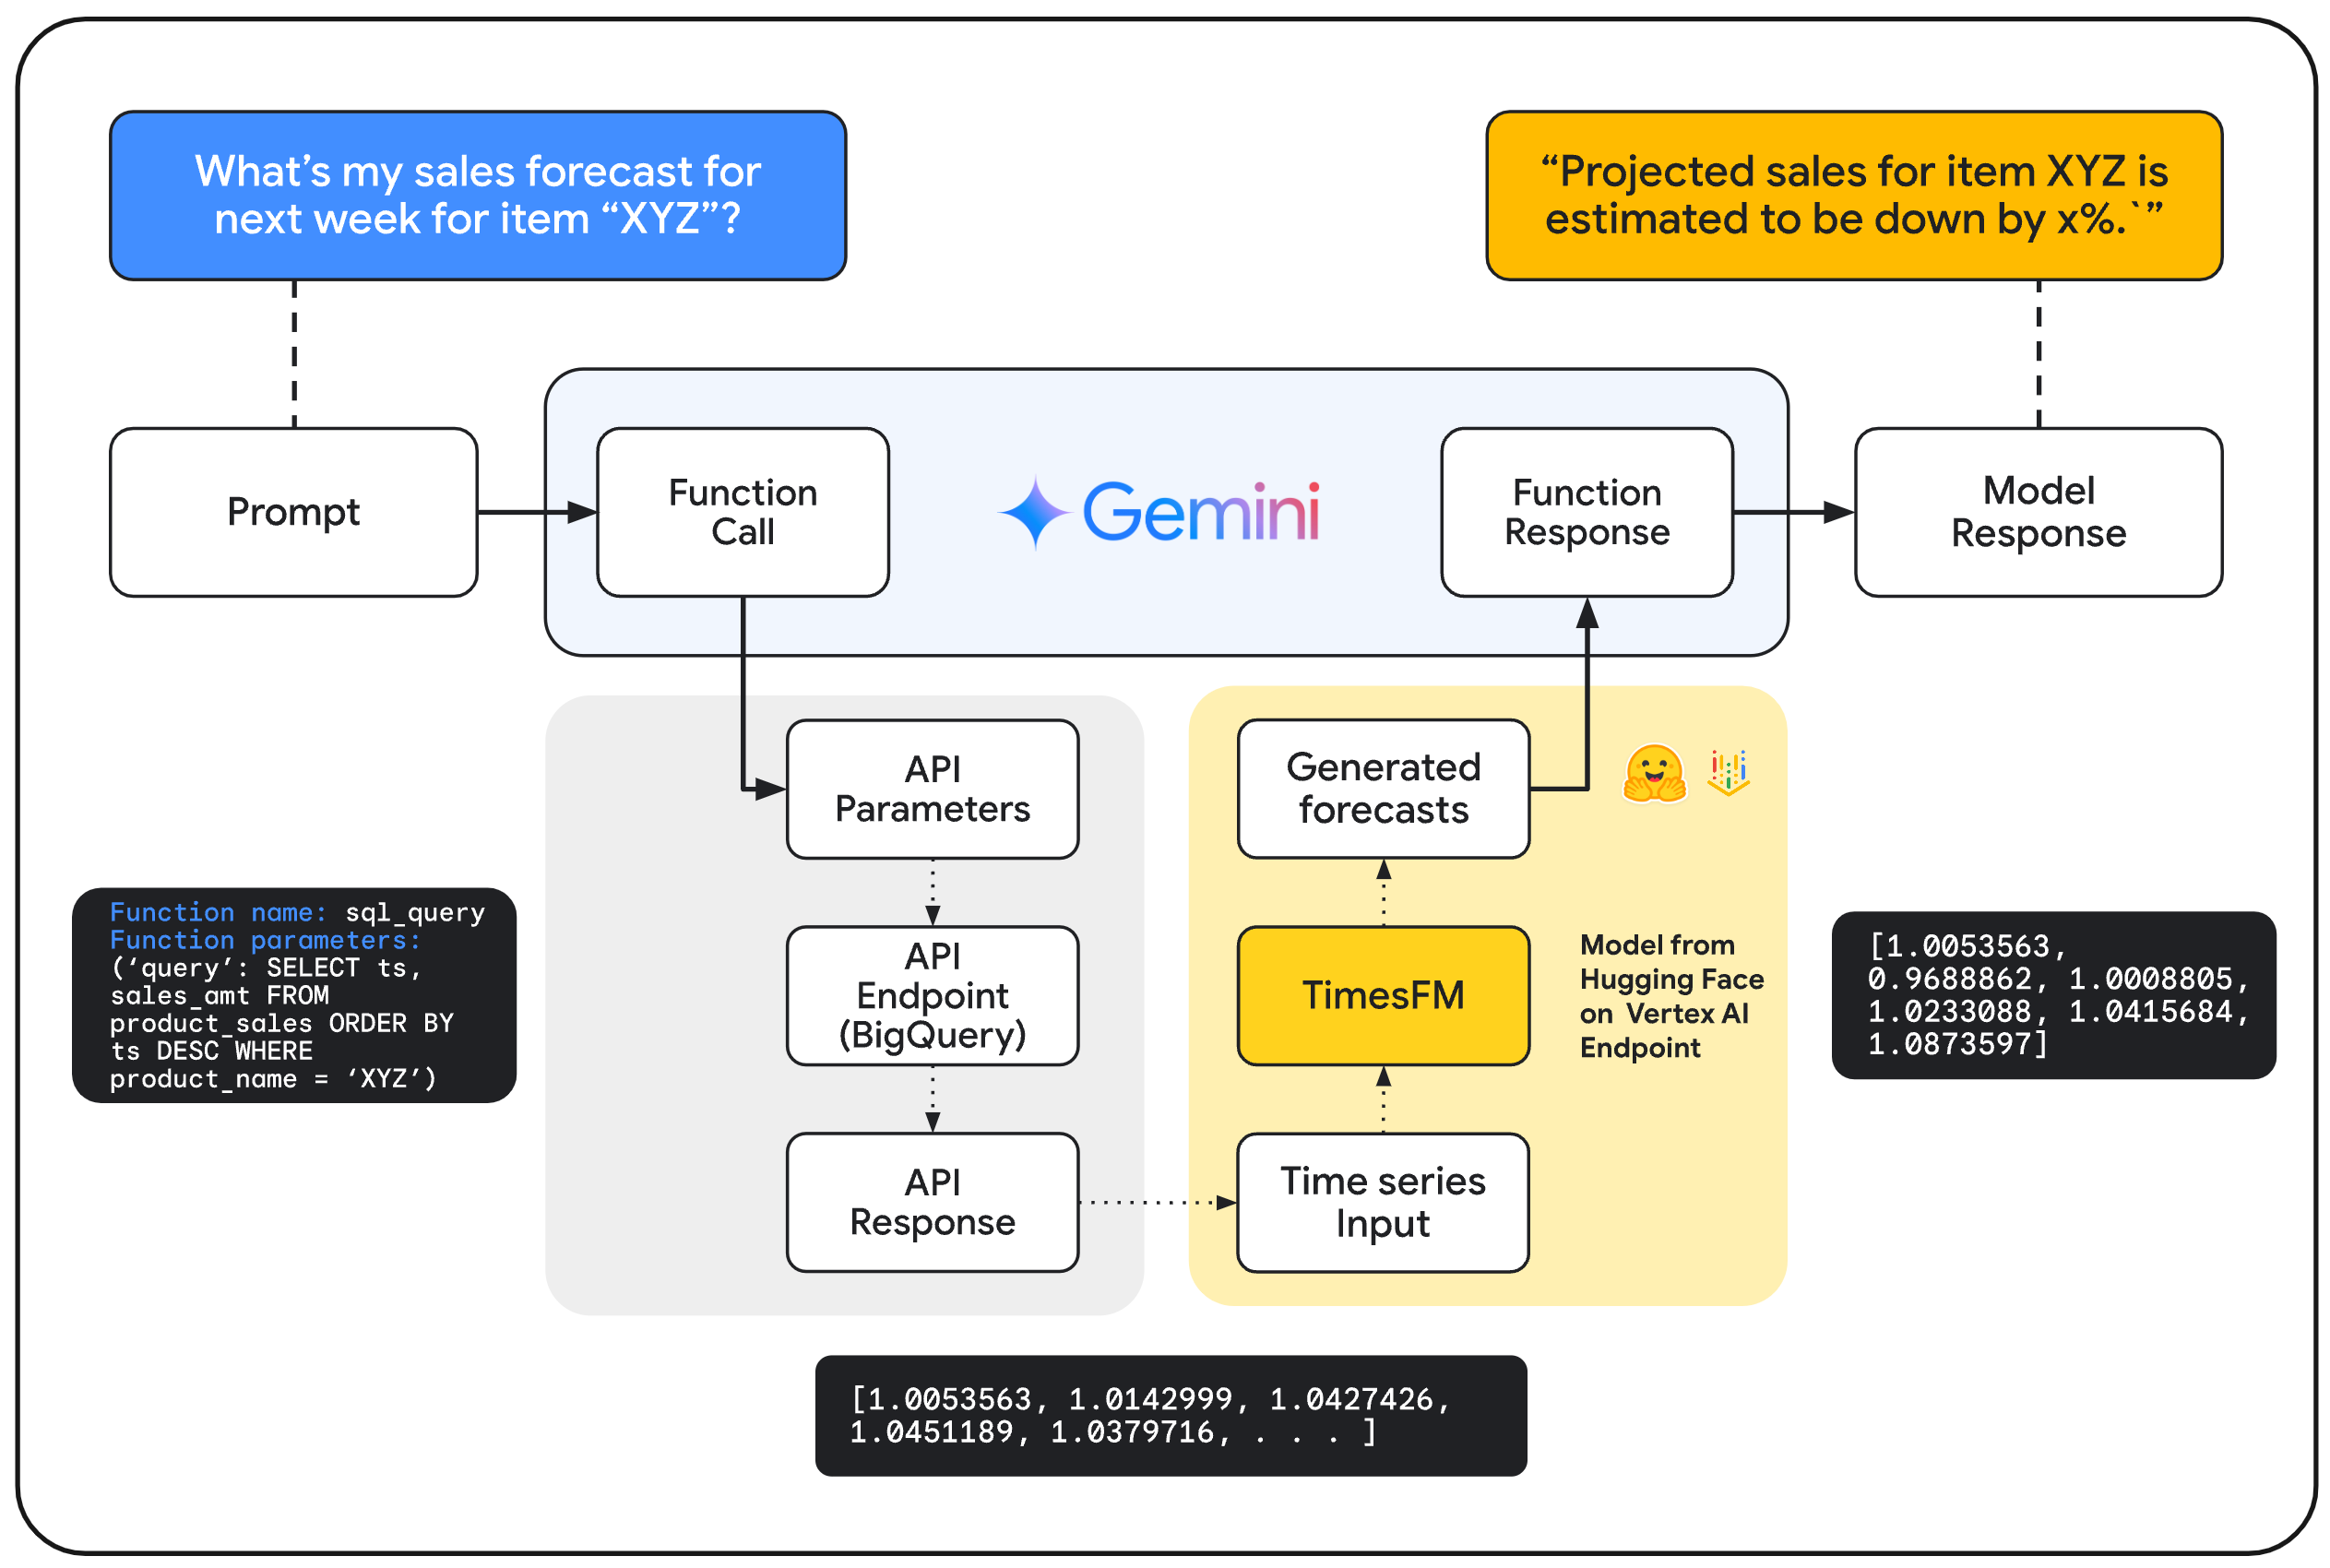

---

## 🎬 Getting Started

The following steps are necessary to run this notebook, no matter what notebook environment you're using.

If you're entirely new to Google Cloud, [get started here](https://cloud.google.com/docs/get-started).

### Google Cloud Project Setup

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.
1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).
1. [Enable the Service Usage API](https://console.cloud.google.com/apis/library/serviceusage.googleapis.com)
1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).
1. [Enable the Cloud Storage API](https://console.cloud.google.com/flows/enableapi?apiid=storage.googleapis.com).
1. [Enable the Cloud BigQuery API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery.googleapis.com).
1. [Enable the Cloud Resource Manager API](https://console.cloud.google.com/flows/enableapi?apiid=cloudresourcemanager.googleapis.com).

### Google Cloud Permissions

**To run the complete Notebook,you will need to have the [Owner role](https://cloud.google.com/iam/docs/understanding-roles) for your project. At minimum, you need the following [roles](https://cloud.google.com/iam/docs/granting-changing-revoking-access)**:
* **`roles/serviceusage.serviceUsageAdmin`** to enable APIs
* **`roles/iam.serviceAccountAdmin`** to modify service agent permissions
* **`roles/aiplatform.user`** to use AI Platform components
* **`roles/storage.objectAdmin`** to modify and delete GCS buckets
* **`roles/bigquery.user`** and **`roles/bigquery.dataViewer`** to query BigQuery tables
* **`roles/bigquery.jobUser`** to run BigQuery jobs
* **`roles/secretmanager.secretAccessor`** to access secret versions in Cloud Secret Manager

### Install Vertex AI SDK and other required packages

- Write requirements.txt file

In [ ]:
PATH_TO_REQUIREMENTS_TXT = "requirements.txt"

In [ ]:
%%writefile $PATH_TO_REQUIREMENTS_TXT
google-cloud-storage
google-cloud-secret-manager
google-cloud-bigquery
google-cloud-bigquery-storage
google-cloud-secret-manager
google-cloud-aiplatform
google-cloud-aiplatform[prediction]>=1.16.0
kaggle
pandas
db-dtypes
numpy
matplotlib
langchain==0.1.20
langchainhub==0.1.15
langchain-google-vertexai==1.0.3
cloudpickle==3.0.0
pydantic==2.7.1
protobuf==3.19.6

In [ ]:
import sys

if "google.colab" in sys.modules:
    USER_FLAG = ""
else:
    USER_FLAG = "--user"

In [ ]:
! pip install $USER_FLAG -r $PATH_TO_REQUIREMENTS_TXT -q --no-warn-conflicts

### Restart Runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

You may see the restart reported as a crash, but it is working as-intended -- you are merely restarting the runtime.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate

If you're using Colab, run the code in the next cell. Follow the popups and authenticate with an account that has access to your Google Cloud [project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#identifying_projects).

If you're running this notebook somewhere besides Colab, make sure your environment has the right Google Cloud access. If that's a new concept to you, consider looking into [Application Default Credentials for your local environment](https://cloud.google.com/docs/authentication/provide-credentials-adc#local-dev) and [initializing the Google Cloud CLI](https://cloud.google.com/docs/authentication/gcloud). In many cases, running `gcloud auth application-default login` in a shell on the machine running the notebook kernel is sufficient.

More authentication options are discussed [here](https://cloud.google.com/docs/authentication).

In [ ]:
# Colab authentication.
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()
    print("Authenticated")

### Set Google Cloud project information

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

Make sure to change `PROJECT_ID` in the next cell. You can leave the values for `LOCATION`unless you have a specific reason to change them.

In [ ]:
# Define variables
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
STAGING_BUCKET = "[your-bucket-name]"  # @param {type:"string"}
STAGING_BUCKET_URI = f"gs://{STAGING_BUCKET}"

### Enable required Google Cloud APIs

In [ ]:
# Enable required APIs
! gcloud services enable \
    iam.googleapis.com \
    storage-component.googleapis.com \
    compute.googleapis.com \
    aiplatform.googleapis.com \
    bigquery.googleapis.com \
    secretmanager.googleapis.com \
    cloudresourcemanager.googleapis.com \
    --project $PROJECT_ID

### Initialize Vertex AI SDK

In [ ]:
import os
import sys

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=STAGING_BUCKET_URI)

print("Vertex AI SDK initialized.")
print(f"Vertex AI SDK version = {vertexai.__version__}")

### Create staging Cloud Storage bucket

In [ ]:
from datetime import datetime

print(f"Using this region: {LOCATION}")

now = datetime.now().strftime("%Y%m%d%H%M%S")
assert STAGING_BUCKET_URI.startswith(
    "gs://"
), "STAGING_BUCKET_URI must start with `gs://`."

# Create a unique GCS bucket for this notebook, if not specified by the user
if (
    STAGING_BUCKET_URI is None
    or STAGING_BUCKET_URI.strip() == ""
    or STAGING_BUCKET_URI == "gs://"
):
    STAGING_BUCKET_URI = f"gs://{PROJECT_ID}-tmp-{now}"
    ! gsutil mb -l {REGION} {STAGING_BUCKET_URI}
else:
    STAGING_BUCKET_NAME = "/".join(STAGING_BUCKET_URI.split("/")[:3])
    shell_output = ! gsutil ls -Lb {STAGING_BUCKET_NAME} | grep "Location constraint:" | sed "s/Location constraint://"
    bucket_region = shell_output[0].strip().lower()
    if not LOCATION.startswith(bucket_region):
        raise ValueError(
            f"Bucket region {bucket_region} is different from notebook region"
            f" {LOCATION}"
        )
print(f"Using this GCS Bucket: {STAGING_BUCKET_URI}")

### Configure secrets

This notebooks accesses datasets on Kaggle. To access the dataset from Kaggle, you'll need [Kaggle API Key/Token](https://www.kaggle.com/docs/api). There are a few ways to manage these API keys depending on what environment you are using to run this notebook.

<div class="alert alert-block alert-danger">
<b>⚠️ Mishandling API tokens or secret credentials can lead to unauthorized access and data breaches. Never hardcode these values directly into your code. Utilize secure storage solutions like Cloud Secret Manager or Colab Secrets. ⚠️</b>
</div>

**Option #1. Use Google Cloud Secrets Manager**

Follow this [step-by-step guide](https://cloud.google.com/secret-manager/docs/create-secret-quickstart#secretmanager-quickstart-console) to add Kaggle API key as secrets using Cloud Secret Manager. Use following names as secret ids.

- `KAGGLE_KEY`

The following code fetches secret versions and sets appropriate environment variables for rest of the notebook to work.

In [ ]:
from google.cloud import secretmanager


class SecretManager:
    def __init__(self, project_id: str):
        self.project_id = project_id
        self._client = secretmanager.SecretManagerServiceClient()

    def get_secret(self, secret_id: str):
        name = self._client.secret_version_path(self.project_id, secret_id, "latest")
        response = self._client.access_secret_version(name=name)
        return response.payload.data.decode("UTF-8")


sm = SecretManager(project_id=PROJECT_ID)
os.environ["KAGGLE_USERNAME"] = sm.get_secret("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = sm.get_secret("KAGGLE_KEY")

**Option #2. Using Colab Secrets**

You can safely store your private keys, such as your huggingface or kaggle API tokens, in Colab Secrets. Values stored in Secrets are private, visible only to you and the notebooks you select.

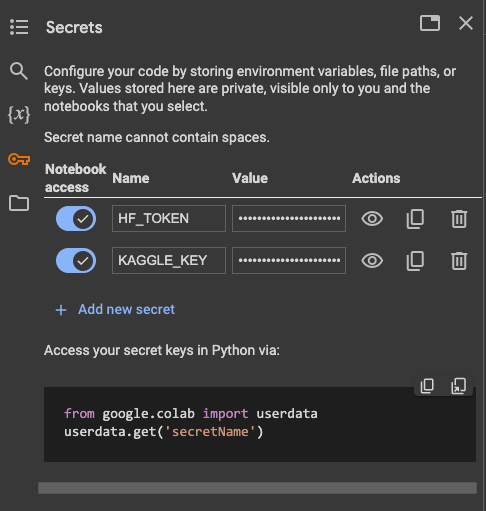

In [ ]:
if "google.colab" in sys.modules:
    from google.colab import userdata

    os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
    os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

**Option #3. Use Python configuration file**

Add HuggingFace token and Kaggle API key to the configuration file.

**DO NOT commit configuration file to GitHub repository.**

In [ ]:
%%writefile config.ini
[kaggle]
KAGGLE_USERNAME = xxxxxxx # REPLACE WITH KAGGLE USERNAME
KAGGLE_KEY = xxxxxxx # REPLACE WITH KAGGLE API KEY

In [ ]:
import configparser

# read configuration file and set env variables
config = configparser.ConfigParser()
config.read("config.ini")

os.environ["KAGGLE_USERNAME"] = config["kaggle"]["KAGGLE_USERNAME"]
os.environ["KAGGLE_KEY"] = config["kaggle"]["KAGGLE_KEY"]

---

# Let's Build!

The notebook is divided into sections as shown:

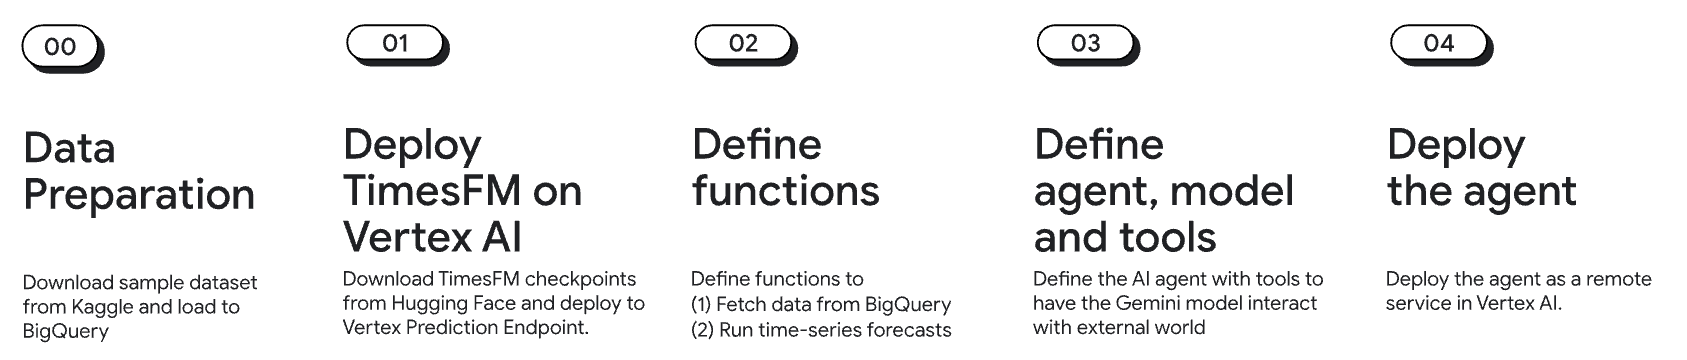

---

## 👨‍🍳 00 - Data Preparation

In this section, we prepare data required for rest of the steps. We use [e-commerce sales data](https://www.kaggle.com/datasets/thedevastator/unlock-profits-with-e-commerce-sales-data?resource=download&select=Amazon+Sale+Report.csv) from Kaggle. Please check the link for terms of use of the dataset featured in this notebook.

- Configure variables

In [ ]:
# Kaggle dataset
KAGGLE_DATASET = "thedevastator/unlock-profits-with-e-commerce-sales-data"

# paths for managing data locally and Cloud Storage bucket
LOCAL_DATA_PATH = "data"
GCS_DATA_PATH = f"{STAGING_BUCKET_URI}/googleio24/data/amazon_sale_report.csv"

# BigQuery datasets
BQ_DATASET_ID = "[your-bq-dataset-id]"  # @param {type:"string"}
BQ_LOCATION = "US"
BQ_TABLE_SALES_RAW = "sales_raw"
BQ_TABLE_SALES_DAILY = "sales_daily"

- Create local directory

In [ ]:
! mkdir -p $LOCAL_DATA_PATH

- [Authenticate](https://www.kaggle.com/docs/api#getting-started-installation-&-authentication) with Kaggle API

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

kgl_api = KaggleApi()
kgl_api.authenticate()

In [ ]:
from google.cloud import bigquery

bq_client = bigquery.Client(project=PROJECT_ID)

### Step 1. Download dataset from Kaggle

- List files within Kaggle dataset

In [ ]:
kgl_api.dataset_list_files(KAGGLE_DATASET).files

- Download specific file from the Kaggle dataset

In [ ]:
kgl_api.dataset_download_file(
    KAGGLE_DATASET, file_name="Amazon Sale Report.csv", path=LOCAL_DATA_PATH
)

# unzip file
! unzip -f $LOCAL_DATA_PATH/*.zip -d $LOCAL_DATA_PATH && ls -ltr $LOCAL_DATA_PATH

- Copy downloaded files to Cloud Storage bucket

In [ ]:
! gsutil cp $LOCAL_DATA_PATH/'Amazon Sale Report.csv' $GCS_DATA_PATH

### Step 2. Create BigQuery dataset

In [ ]:
# create dataset
! set -x && bq mk --force=true \
    --project_id $PROJECT_ID \
    --location $BQ_LOCATION \
    --dataset $BQ_DATASET_ID

### Step 3. Load dataset to BigQuery table

In [ ]:
load_sql = f"""LOAD DATA OVERWRITE `{PROJECT_ID}.{BQ_DATASET_ID}.{BQ_TABLE_SALES_RAW}`
  FROM FILES(
    format='CSV',
    skip_leading_rows=1,
    uris = ['{GCS_DATA_PATH}']
  )
"""

job = bq_client.query(load_sql)  # API request.
job.result()  # Waits for the query to finish.

print(f"Data loaded into {PROJECT_ID}.{BQ_DATASET_ID}.{BQ_TABLE_SALES_RAW}")

### Step 4. Prepare and transform data in BigQuery table

Prepare data by adding transformations to interpolate missing data points using BigQuery time series functions such as [`GAP_FILL` and time series windowing](https://cloud.google.com/blog/products/data-analytics/bigquery-sql-gets-time-windowing-and-gap-filling).

In [ ]:
ddl_sql = f"""CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET_ID}.{BQ_TABLE_SALES_DAILY}` AS
(
WITH daily_sales AS (
  SELECT
    DATE_BUCKET(date, INTERVAL 1 DAY) AS date,
    ROUND(SUM(AMOUNT), 2) AS total_sales,
    ROUND(SUM(QTY), 2) AS total_qty,
    sku
  FROM `{PROJECT_ID}.{BQ_DATASET_ID}.{BQ_TABLE_SALES_RAW}`
  GROUP BY date, sku
)
SELECT
  date,
  sku,
  IFNULL(total_sales, 0) total_sales,
  IFNULL(total_qty, 0) total_inventory
FROM (
  SELECT
    date,
    sku,
    total_sales,
    total_qty
  FROM GAP_FILL(
    TABLE daily_sales,
    ts_column => 'date',
    bucket_width => INTERVAL 1 DAY,
    partitioning_columns => ['sku'],
    value_columns => [
      ('total_sales', 'null'),
      ('total_qty', 'null')
    ]
  )
 )
)
"""

job = bq_client.query(ddl_sql)  # API request.
job.result()  # Waits for the query to finish.

print(
    f"Data prepared and loaded into {PROJECT_ID}.{BQ_DATASET_ID}.{BQ_TABLE_SALES_DAILY}"
)

- Run few SQL queries to find # of SKUs and sample data for a SKU.

In [ ]:
query = f"""SELECT sku, COUNTIF(total_sales<>0) CNT
FROM `{PROJECT_ID}.{BQ_DATASET_ID}.{BQ_TABLE_SALES_DAILY}`
GROUP BY sku
ORDER BY 2 DESC
"""

bq_client.query(query).to_dataframe()

In [ ]:
query = f"""SELECT date, sku, total_sales, total_inventory
FROM `{PROJECT_ID}.{BQ_DATASET_ID}.{BQ_TABLE_SALES_DAILY}`
WHERE sku = 'J0230-SKD-M'
ORDER BY DATE"""

bq_client.query(query).to_dataframe()

## 🪂 01 - Deploy TimesFM on Vertex AI Endpoint from Vertex AI Model Garden

This steps deploys TimesFM model to Vertex AI Endpoint from [Vertex AI Model Garden](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/timesfm). 

The [TimesFM](https://arxiv.org/abs/2310.10688) is a 200M parameter transformer based model trained in the decoder only fashion on a pretrain dataset containing over 100 billion real-world timepoints. It performs univariate time series forecasting for context lengths up to 512 timepoints and any horizon lengths, with an optional frequency indicator input.

TimesFM model can be used for times series forecasting and the model takes as input context a univariate time series, along with an optional frequency parameter. The model forecasts the time series into a future horizon of any length.

### Step 1. Set up prediction environment

- Import libraries

In [ ]:
import json
import os
# Import the necessary packages
from datetime import datetime
from typing import Tuple

import numpy as np
import pandas as pd
from google.cloud import aiplatform
from google.cloud.aiplatform.prediction import LocalModel

- Configure staging bucket for model artifacts

In [ ]:
STAGING_BUCKET = os.path.join(STAGING_BUCKET_URI, "temporal")
MODEL_BUCKET = os.path.join(STAGING_BUCKET_URI, "timesfm")

- Setting up default service account

In [ ]:
# Set up default SERVICE_ACCOUNT
SERVICE_ACCOUNT = None
shell_output = ! gcloud projects describe $PROJECT_ID
project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"
print("Using this default Service Account:", SERVICE_ACCOUNT)

- Provision permissions to the service account with the Cloud Storage bucket

In [ ]:
# Provision permissions to the SERVICE_ACCOUNT with the GCS bucket
BUCKET_NAME = "/".join(STAGING_BUCKET_URI.split("/")[:3])
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.admin $BUCKET_NAME

### Step 2. Copy TimesFM model artifacts to staging bucket

In [ ]:
VERTEX_AI_MODEL_GARDEN_TIMESFM = "gs://vertex-model-garden-public-us/timesfm"  # @param {type:"string", isTemplate:true} ["gs://vertex-model-garden-public-us/timesfm", "gs://vertex-model-garden-public-eu/timesfm", "gs://vertex-model-garden-public-asia/timesfm"]
MODEL_VARIANT = "timesfm-1.0-200m"  # @param ["timesfm-1.0-200m"]

print(
    "Copying TimesFM model artifacts from",
    f"{VERTEX_AI_MODEL_GARDEN_TIMESFM}/{MODEL_VARIANT}",
    "to",
    MODEL_BUCKET,
)

! gsutil -m cp -r -R $VERTEX_AI_MODEL_GARDEN_TIMESFM/$MODEL_VARIANT $MODEL_BUCKET

checkpoint_path = MODEL_BUCKET

In [ ]:
! gsutil ls $checkpoint_path

### Step 3. Define utility functions to deploy the model

- Set TimesFM prebuilt serving docker image

In [ ]:
# The pre-built serving docker images.
SERVE_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/jax-timesfm-serve:20240528_1310_RC00"

- Utility function to deploy the model

In [ ]:
# @title utility functions to deploy the model
def get_job_name_with_datetime(prefix: str) -> str:
    """Gets the job name with date time when triggering training or deployment

    jobs in Vertex AI.
    """
    return prefix + datetime.now().strftime("_%Y%m%d_%H%M%S")


def deploy_model(
    model_name: str,
    checkpoint_path: str,
    horizon: str,
    machine_type: str = "g2-standard-4",
    accelerator_type: str = "NVIDIA_L4",
    accelerator_count: int = 1,
    deploy_source: str = "notebook",
) -> Tuple[aiplatform.Model, aiplatform.Endpoint]:
    """Create a Vertex AI Endpoint and deploy the specified model to the endpoint."""
    model_name_with_time = get_job_name_with_datetime(model_name)

    endpoints = aiplatform.Endpoint.list(filter=f'display_name="{model_name}-endpoint"')

    if len(endpoints) > 0:
        print(f"Using existing endpoint {endpoints[0].resource_name}")
        endpoint = aiplatform.Endpoint(endpoints[0].resource_name)
    else:
        print(f"Creating a new endpoint {model_name}-endpoint")
        endpoint = aiplatform.Endpoint.create(
            display_name=f"{model_name}-endpoint",
            credentials=aiplatform.initializer.global_config.credentials,
        )

    if accelerator_type == "ACCELERATOR_TYPE_UNSPECIFIED":
        timesfm_backend = "cpu"
        accelerator_type = None
    elif accelerator_type.startswith("NVIDIA"):
        timesfm_backend = "gpu"
    else:
        timesfm_backend = "tpu"

    model = aiplatform.Model.upload(
        display_name=model_name_with_time,
        artifact_uri=checkpoint_path,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[8080],
        serving_container_predict_route="/predict",
        serving_container_health_route="/health",
        serving_container_environment_variables={
            "DEPLOY_SOURCE": deploy_source,
            "TIMESFM_HORIZON": str(horizon),
            "TIMESFM_BACKEND": timesfm_backend,
        },
        credentials=aiplatform.initializer.global_config.credentials,
    )
    print(
        f"Deploying {model_name_with_time} on {machine_type} with"
        f" {accelerator_count} {accelerator_type} GPU(s)."
    )
    model.deploy(
        endpoint=endpoint,
        machine_type=machine_type,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        deploy_request_timeout=1800,
        service_account=SERVICE_ACCOUNT,
        enable_access_logging=True,
        min_replica_count=1,
        sync=True,
    )
    return model, endpoint


def get_quota(project_id: str, region: str, resource_id: str) -> int:
    """Returns the quota for a resource in a region.

    Returns -1 if can not figure out the quota.
    """
    quota_list_output = !gcloud alpha services quota list --service="aiplatform.googleapis.com"  --consumer=projects/$project_id --filter="$service_endpoint/$resource_id" --format=json
    # Use '.s' on the command output because it is an SList type.
    quota_data = json.loads(quota_list_output.s)
    if len(quota_data) == 0 or "consumerQuotaLimits" not in quota_data[0]:
        return -1
    if (
        len(quota_data[0]["consumerQuotaLimits"]) == 0
        or "quotaBuckets" not in quota_data[0]["consumerQuotaLimits"][0]
    ):
        return -1
    all_regions_data = quota_data[0]["consumerQuotaLimits"][0]["quotaBuckets"]
    for region_data in all_regions_data:
        if (
            region_data.get("dimensions")
            and region_data["dimensions"]["region"] == region
        ):
            if "effectiveLimit" in region_data:
                return int(region_data["effectiveLimit"])
            else:
                return 0
    return -1


def get_resource_id(accelerator_type: str, is_for_training: bool) -> str:
    """Returns the resource id for a given accelerator type and the use case.

    Args:
      accelerator_type: The accelerator type.
      is_for_training: Whether the resource is used for training. Set false for
        serving use case.

    Returns:
      The resource id.
    """
    training_accelerator_map = {
        "NVIDIA_TESLA_V100": "custom_model_training_nvidia_v100_gpus",
        "NVIDIA_L4": "custom_model_training_nvidia_l4_gpus",
        "NVIDIA_TESLA_A100": "custom_model_training_nvidia_a100_gpus",
        "ACCELERATOR_TYPE_UNSPECIFIED": "custom_model_training_cpus",
    }
    serving_accelerator_map = {
        "NVIDIA_TESLA_V100": "custom_model_serving_nvidia_v100_gpus",
        "NVIDIA_L4": "custom_model_serving_nvidia_l4_gpus",
        "NVIDIA_TESLA_A100": "custom_model_serving_nvidia_a100_gpus",
        "ACCELERATOR_TYPE_UNSPECIFIED": "custom_model_serving_cpus",
    }
    if is_for_training:
        if accelerator_type in training_accelerator_map:
            return training_accelerator_map[accelerator_type]
        else:
            raise ValueError(
                f"Could not find accelerator type: {accelerator_type} for training."
            )
    else:
        if accelerator_type in serving_accelerator_map:
            return serving_accelerator_map[accelerator_type]
        else:
            raise ValueError(
                f"Could not find accelerator type: {accelerator_type} for serving."
            )


def check_quota(
    project_id: str,
    region: str,
    accelerator_type: str,
    accelerator_count: int,
    is_for_training: bool,
):
    """Checks if the project and the region has the required quota."""
    resource_id = get_resource_id(accelerator_type, is_for_training)
    quota = get_quota(project_id, region, resource_id)
    quota_request_instruction = (
        "Either use "
        "a different region or request additional quota. Follow "
        "instructions here "
        "https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota"
        " to check quota in a region or request additional quota for "
        "your project."
    )
    if quota == -1:
        raise ValueError(
            f"""Quota not found for: {resource_id} in {region}.
            {quota_request_instruction}"""
        )
    if quota < accelerator_count:
        raise ValueError(
            f"""Quota not enough for {resource_id} in {region}:
            {quota} < {accelerator_count}.
            {quota_request_instruction}"""
        )

### Step 6. Run the container locally *[Optional]*

In [ ]:
DEFAULT_HTTP_PORT = 7080

local_model = LocalModel(
    serving_container_image_uri=SERVE_DOCKER_URI,
    serving_container_predict_route="/predict",
    serving_container_health_route="/health",
    serving_container_ports=[DEFAULT_HTTP_PORT],
)

- You can inspect the container's spec to get useful information such as image URI and environment variables.

In [ ]:
local_model.get_serving_container_spec()

- Deploy the model to local endpoint and send a prediction request

In [ ]:
instances = [
    {"input": np.sin(np.linspace(0, 20, 100)).tolist(), "freq": 0},
    {"input": np.sin(np.linspace(0, 40, 500)).tolist(), "freq": 0},
    {
        "input": (
            np.sin(np.linspace(0, 50, 300)) + np.sin(np.linspace(1, 71, 300)) * 0.5
        ).tolist(),
        "freq": 0,
    },
]
payload = {"instances": instances}

with open("payload.json", "w") as f:
    json.dump(payload, f)

In [ ]:
with local_model.deploy_to_local_endpoint(
    artifact_uri=f"{MODEL_BUCKET}",
    host_port=DEFAULT_HTTP_PORT,
    container_ready_timeout=1500,
) as local_endpoint:
    health_check_response = local_endpoint.run_health_check()
    predict_response = local_endpoint.predict(
        request_file="payload.json", headers={"Content-Type": "application/json"}
    )

- Print out the predict response, health check response and its content.

In [ ]:
print(health_check_response, health_check_response.content)
print(predict_response, predict_response.content)

- Also print out all the container logs. You will see the logs of container startup, serving requests, and container teardown.

In [ ]:
local_endpoint.print_container_logs_if_container_is_not_running(show_all=True)
# local_endpoint.print_container_logs(show_all=True)

### Step 7. Deploy the TimesFM to Vertex AI endpoint

In [ ]:
print(f"Loading checkpoint from {MODEL_BUCKET}.")

- Choose the backend (accelerator type) to use to deploy the model.

<div class="alert alert-block alert-info">
    <b> ⓘ 
        <li> TimesFM is fast even with the CPU backend. Consider GPU only if you need to handle large queries per second. </li>
        <li> After deployment, please take a look at the log to get the model / endpoint that you can use in another session. </li>
    </b>
</div>

In [ ]:
accelerator_type = "CPU"  # @param ["CPU", "NVIDIA_L4"]
if accelerator_type == "NVIDIA_L4":
    machine_type = "g2-standard-4"
    accelerator_count = 1
elif accelerator_type == "CPU":
    accelerator_type = "ACCELERATOR_TYPE_UNSPECIFIED"
    machine_type = "n1-standard-8"
    accelerator_count = 0
else:
    raise ValueError(
        f"Recommended machine settings not found for: {accelerator_type}. To use"
        " another another accelerator, edit this code block to pass in an"
        " appropriate `machine_type`, `accelerator_type`, and"
        " `accelerator_count` to the deploy_model function by clicking `Show"
        " Code` and then modifying the code."
    )

if accelerator_type != "ACCELERATOR_TYPE_UNSPECIFIED":
    check_quota(
        project_id=PROJECT_ID,
        region=REGION,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        is_for_training=False,
    )

print("Quota is OK.")

- Specify the forecast horizon TimesFM will be queried on to compile its computation. 

In [ ]:
horizon = 256  # @param {type:"number"}

- Deploy model to endpoint if does not exist

<div class="alert alert-block alert-warning">
<b>⚠️ Deployment may take upto 20 minutes. Please be patient... ⚠️</b>
</div>

In [ ]:
print("Creating endpoint.")

TIMESFM_MODEL_DISPLAY_NAME = f"timesfm-{MODEL_VARIANT}"
TIMESFM_ENDPOINT_DISPLAY_NAME = f"{TIMESFM_MODEL_DISPLAY_NAME}-endpoint"

model, endpoint = deploy_model(
    model_name=TIMESFM_MODEL_DISPLAY_NAME,
    checkpoint_path=checkpoint_path,
    horizon=horizon,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
)

In [ ]:
endpoints = aiplatform.Endpoint.list(
    filter=f'display_name="{TIMESFM_ENDPOINT_DISPLAY_NAME}"'
)

if len(endpoints) > 0:
    endpoint = aiplatform.Endpoint(endpoints[0].resource_name)
else:
    raise Exception(
        f"Endpoint does not exist with name {TIMESFM_ENDPOINT_DISPLAY_NAME}"
    )

In [ ]:
with open("payload.json") as f:
    response = endpoint.predict(**json.load(f))

In [ ]:
! cat payload.json | jq -c

In [ ]:
pd.DataFrame(response.predictions).head()

## 🛠️ 02 - Define functions

To start, we’ll need to define functions that Gemini will use as tools to interact with external systems and APIs to retrieve real-time information. You just write Python functions and use them as tools when defining the agent!

In [ ]:
import ast
from typing import Any, Dict, Sequence

### Step 1. Define functions to interact with BigQuery using Natural Language (NL2SQL)

Define functions to

- ✅ Get list of datasets from BigQuery
- ✅ Get list of tables from a dataset that will help answer user's query
- ✅ Get information about a table including description and schema that will help answer user's query
- ✅ Get information from data in BigQuery by running SQL queries

The function descriptions should be concise and clear, as these descriptions are to the Gemini model for the agent.

In [ ]:
def list_datasets():
    """Get a list of datasets that will help answer the user's question.

    args:
      None
    """
    # from google.cloud import bigquery
    # client = bigquery.Client(project=PROJECT_ID)
    # return [dataset.dataset_id for dataset in list_datasets()]
    return [BQ_DATASET_ID]


def list_tables(dataset_id: str):
    """List tables in a dataset that will help answer the user's question

    args:
      dataset_id (str)     Dataset ID to fetch tables from.
    """
    from google.cloud import bigquery

    client = bigquery.Client(project=PROJECT_ID)
    tables = client.list_tables(dataset_id)
    return str([table.table_id for table in tables])


def get_table(table_id: str):
    """Get information about a table, including the description, schema, and
    number of rows that will help answer the user's question.
    Always use the fully qualified dataset and table names.

    args:
      table_id (str)       Fully qualified ID of the table to get information about
    """
    from google.cloud import bigquery

    client = bigquery.Client(project=PROJECT_ID)
    table = client.get_table(table_id)
    return table.to_api_repr()


def run_sql_query(query: str):
    """Get information from data in BigQuery using SQL queries.

    args:
      query (str)         SQL query on a single line that will help give
         quantitative answers to the user's question when run on a BigQuery
         dataset and table. In the SQL query, always use the fully qualified
         dataset and table names.",
    """
    from google.cloud import bigquery

    client = bigquery.Client(project=PROJECT_ID)
    job_config = bigquery.QueryJobConfig(
        maximum_bytes_billed=100000000
    )  # Data limit per query job
    try:
        cleaned_query = query.replace("\\n", " ").replace("\n", " ").replace("\\", "")
        print(cleaned_query)
        query_job = client.query(cleaned_query, job_config=job_config)
        result = query_job.result()
        result = str([dict(row) for row in result])
        result = result.replace("\\", "").replace("\n", "")
        return result
    except Exception as e:
        result = f"{str(e)}"
        return result

- Run sample queries and test it out

In [ ]:
dataset = [dataset for dataset in list_datasets()][0]
dataset

In [ ]:
get_table(f"{PROJECT_ID}.{BQ_DATASET_ID}.sales_daily")

### Step 2. Define function to get forecasts using TimesFM model on Vertex AI

Define function to
- ✅ Predict forecasts based on historical time-series contexts

In [ ]:
def prepare_timesfm_payload(ts: Sequence[float]) -> Dict[str, Sequence[Any]]:
    """format payload to work forecasting model endpoint"""
    return {"instances": [{"input": ts}]}


def run_forecasts(ts: Sequence[float], return_quantiles: bool = False):
    """Use this function to generate forecasts or estimates based on historical
    time-series contexts such as sales, inventory that you fetch from sales
    tables or related tables. The function returns point forecasts.
    Quantile forecasts are returned when enabled.

    input args:
      ts (Sequence):
        input sequence of time-series context.
      return_quantiles (bool):
        return quantile forecasts when enabled.

    returns:
      returns list of point forecasts and quantile forecasts for each of the
      input time-series context.
    """
    aiplatform.init(project=PROJECT_ID, location=LOCATION)
    endpoints = aiplatform.Endpoint.list(
        filter=f'display_name="{TIMESFM_ENDPOINT_DISPLAY_NAME}"'
    )
    endpoint = aiplatform.Endpoint(endpoints[0].resource_name)

    payload = prepare_timesfm_payload(ts)
    forecasts = endpoint.predict(**payload)
    num_horizon = 30
    if len(forecasts.predictions) > 0:
        point_forecast = forecasts.predictions[0]["point_forecast"][:num_horizon]
        if return_quantiles:
            qf_data = forecasts.predictions[0]["quantile_forecast"]
            quantile_forecast = list(zip(*qf_data[:num_horizon]))
            return point_forecast, quantile_forecast
        else:
            return (point_forecast,)
    else:
        return "Failed to generate forecasts"

### Step 3. Run a few tests and plot forecasts

- Define a SKU

In [ ]:
# sku = "JNE3797-KR-XXXL"
sku = "J0230-SKD-M"

- Get historical time-series context for SKU

In [ ]:
query = f"""
SELECT total_inventory
FROM `{PROJECT_ID}.{BQ_DATASET_ID}.sales_daily`
WHERE sku = '{sku}'
AND date <= DATE_SUB(CURRENT_DATE(), INTERVAL 2 YEAR)
ORDER BY date
"""
print(query)
result = run_sql_query(query)
ts = [row["total_inventory"] for row in ast.literal_eval(result)]

- Call TimesFM model to generate forecasts

In [ ]:
forecasts = run_forecasts(ts, return_quantiles=True)
point_forecast = forecasts[0]
quantile_forecast = list(zip(*forecasts[1])) if len(forecasts) > 1 else []

- Get actual values for the SKU that will be predicted by the model

In [ ]:
query = f"""
SELECT total_inventory
FROM `{PROJECT_ID}.{BQ_DATASET_ID}.sales_daily`
WHERE sku = '{sku}'
AND date > DATE_SUB(CURRENT_DATE(), INTERVAL 2 YEAR)
ORDER BY date
"""
print(query)
result = run_sql_query(query)
ts_actuals = [row["total_inventory"] for row in ast.literal_eval(result)]

- Plot historical time-series with point and quantile forecasts and actuals

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()
sns.set_style("dark")


def visualize_forecast(
    context: list[float],
    horizon_mean: list[float],
    ground_truth: list[float] | None = None,
    horizon_lower: list[float] | None = None,
    horizon_upper: list[float] | None = None,
    ylabel: str | None = None,
    title: str | None = None,
):
    plt_range = list(range(len(context) + len(horizon_mean)))
    plt.figure(figsize=(10, 6))
    plt.plot(
        plt_range,
        context + [np.nan for _ in horizon_mean],
        color="tab:cyan",
        label="context",
    )
    plt.plot(
        plt_range,
        [np.nan for _ in context] + horizon_mean,
        color="tab:red",
        label="forecast",
    )
    if ground_truth:
        plt.plot(
            list(range(len(context) + len(ground_truth))),
            [np.nan for _ in context] + ground_truth,
            color="tab:purple",
            label="ground truth",
        )
    if horizon_upper and horizon_lower:
        plt.plot(
            plt_range,
            [np.nan for _ in context] + horizon_upper,
            color="tab:orange",
            linestyle="--",
            label="forecast, upper",
        )
        plt.plot(
            plt_range,
            [np.nan for _ in context] + horizon_lower,
            color="tab:orange",
            linestyle=":",
            label="forecast, lower",
        )
        plt.fill_between(
            plt_range,
            [np.nan for _ in context] + horizon_upper,
            [np.nan for _ in context] + horizon_lower,
            color="tab:orange",
            alpha=0.2,
        )
    plt.ylabel(ylabel) if ylabel else None
    plt.title(title) if title else None
    plt.xlabel("time")
    plt.legend()
    plt.show()

In [ ]:
visualize_forecast(
    context=ts,
    horizon_mean=point_forecast,
    ground_truth=ts_actuals,
    horizon_lower=[x[2] for x in quantile_forecast],
    horizon_upper=[x[8] for x in quantile_forecast],
    title="forecasts",
    ylabel="inventory",
)

## 🧠 03 - Define Agent with Model and Tools

After defining all of the functions that you want to include as tools in your AI agent, you can define an agent using our LangChain template

### Step 1. Define agent with default LangChain template using Vertex AI Reasoning Engines

In [ ]:
from IPython.display import Markdown, display
from vertexai.preview import reasoning_engines

- Configure the model name to be used for reasoning

In [ ]:
AGENT_MODEL = "gemini-1.5-flash-001"  # @param ["gemini-1.5-flash-001", "gemini-1.0-pro-001", "gemini-1.0-flash-001"]

In [ ]:
model = AGENT_MODEL

agent = reasoning_engines.LangchainAgent(
    model=model,
    model_kwargs={"temperature": 0.3},
    tools=[list_datasets, list_tables, get_table, run_sql_query, run_forecasts],
    agent_executor_kwargs={"return_intermediate_steps": True, "verbose": True},
)
agent.set_up()

prompt_prefix = "REMEMBER: Current date is May 12, 2022. Use tools as needed for generated forecasts after querying table."

Note that the `tools` kwarg includes references to the functions that were described earlier, and the LangChain template in Reasoning Engine introspects the function name, function arguments, default argument values, docstrings, and type hints so that it can pass all of this information as part of the tool description to the agent and Gemini model.

We designed this LangChain template so that you can quickly get started out-of-the-box using default values. We also built the template so that you can have maximum flexibility when customizing the layers of your agent to modify reasoning behavior, generative model parameters, swap out the default agent logic for another type of LangChain agent, or even swap out LangChain for an entirely different orchestration framework!

### Step 2. Run agent locally and understand how it works

In [ ]:
# sku = "JNE3797-KR-XXXL"
sku = "J0230-SKD-M"

In [ ]:
response = agent.query(
    input=f"""{prompt_prefix} What are daily sales for SKU {sku} last 20 days by date?"""
)
display(Markdown(response["output"]))

Let's take a deeper look behind the scenes of this example query and break down what actions the AI agent took at runtime to go from the user’s input prompt to the output that contains a natural language summary of the answer:

1. **User submits a query:** The user sends an input prompt asking about daily sales for a SKU.
2. **Send query and tools to model:** The agent packages the query with tool descriptions and sends it to the Gemini model.
3. **Model decides on tool usage:** Based on the query and tool descriptions, the Gemini model decides whether to utilize a specific function (`run_sql_query`) and which parameters to send as inputs to the function (runs SQL queries on BigQuery dataset).
4. **Application calls the tool:** The application executes the model’s instructions by calling the appropriate function (`list_datasets`, `list_tables`, `get_table`, `run_sql_query`, `run_forecasts`) with the provided parameters.
5. **Tool results:** The application receives a response from the tool (an API response payload).
6. **Return results to model:** The application sends the API response payload to the model.
7. **Return results to agent:** The agent interacts with the model to understand the observation based on the response.
8. **Agent determines next steps:** This process repeats if the agent determines additional tool calls are necessary or if the agent should prepare a final response to send to the user.
9. **Model generates response:** Based on the results from the external API and the agent iterations, the model then generates a natural language response for the user that contains the latest sales and sales forecasts.

**Recommend reading this [reference](https://www.googlecloudcommunity.com/gc/Community-Blogs/Building-and-Deploying-AI-Agents-with-LangChain-on-Vertex-AI/ba-p/748929) to know about Building and Deploying AI Agents with LangChain on Vertex AI**

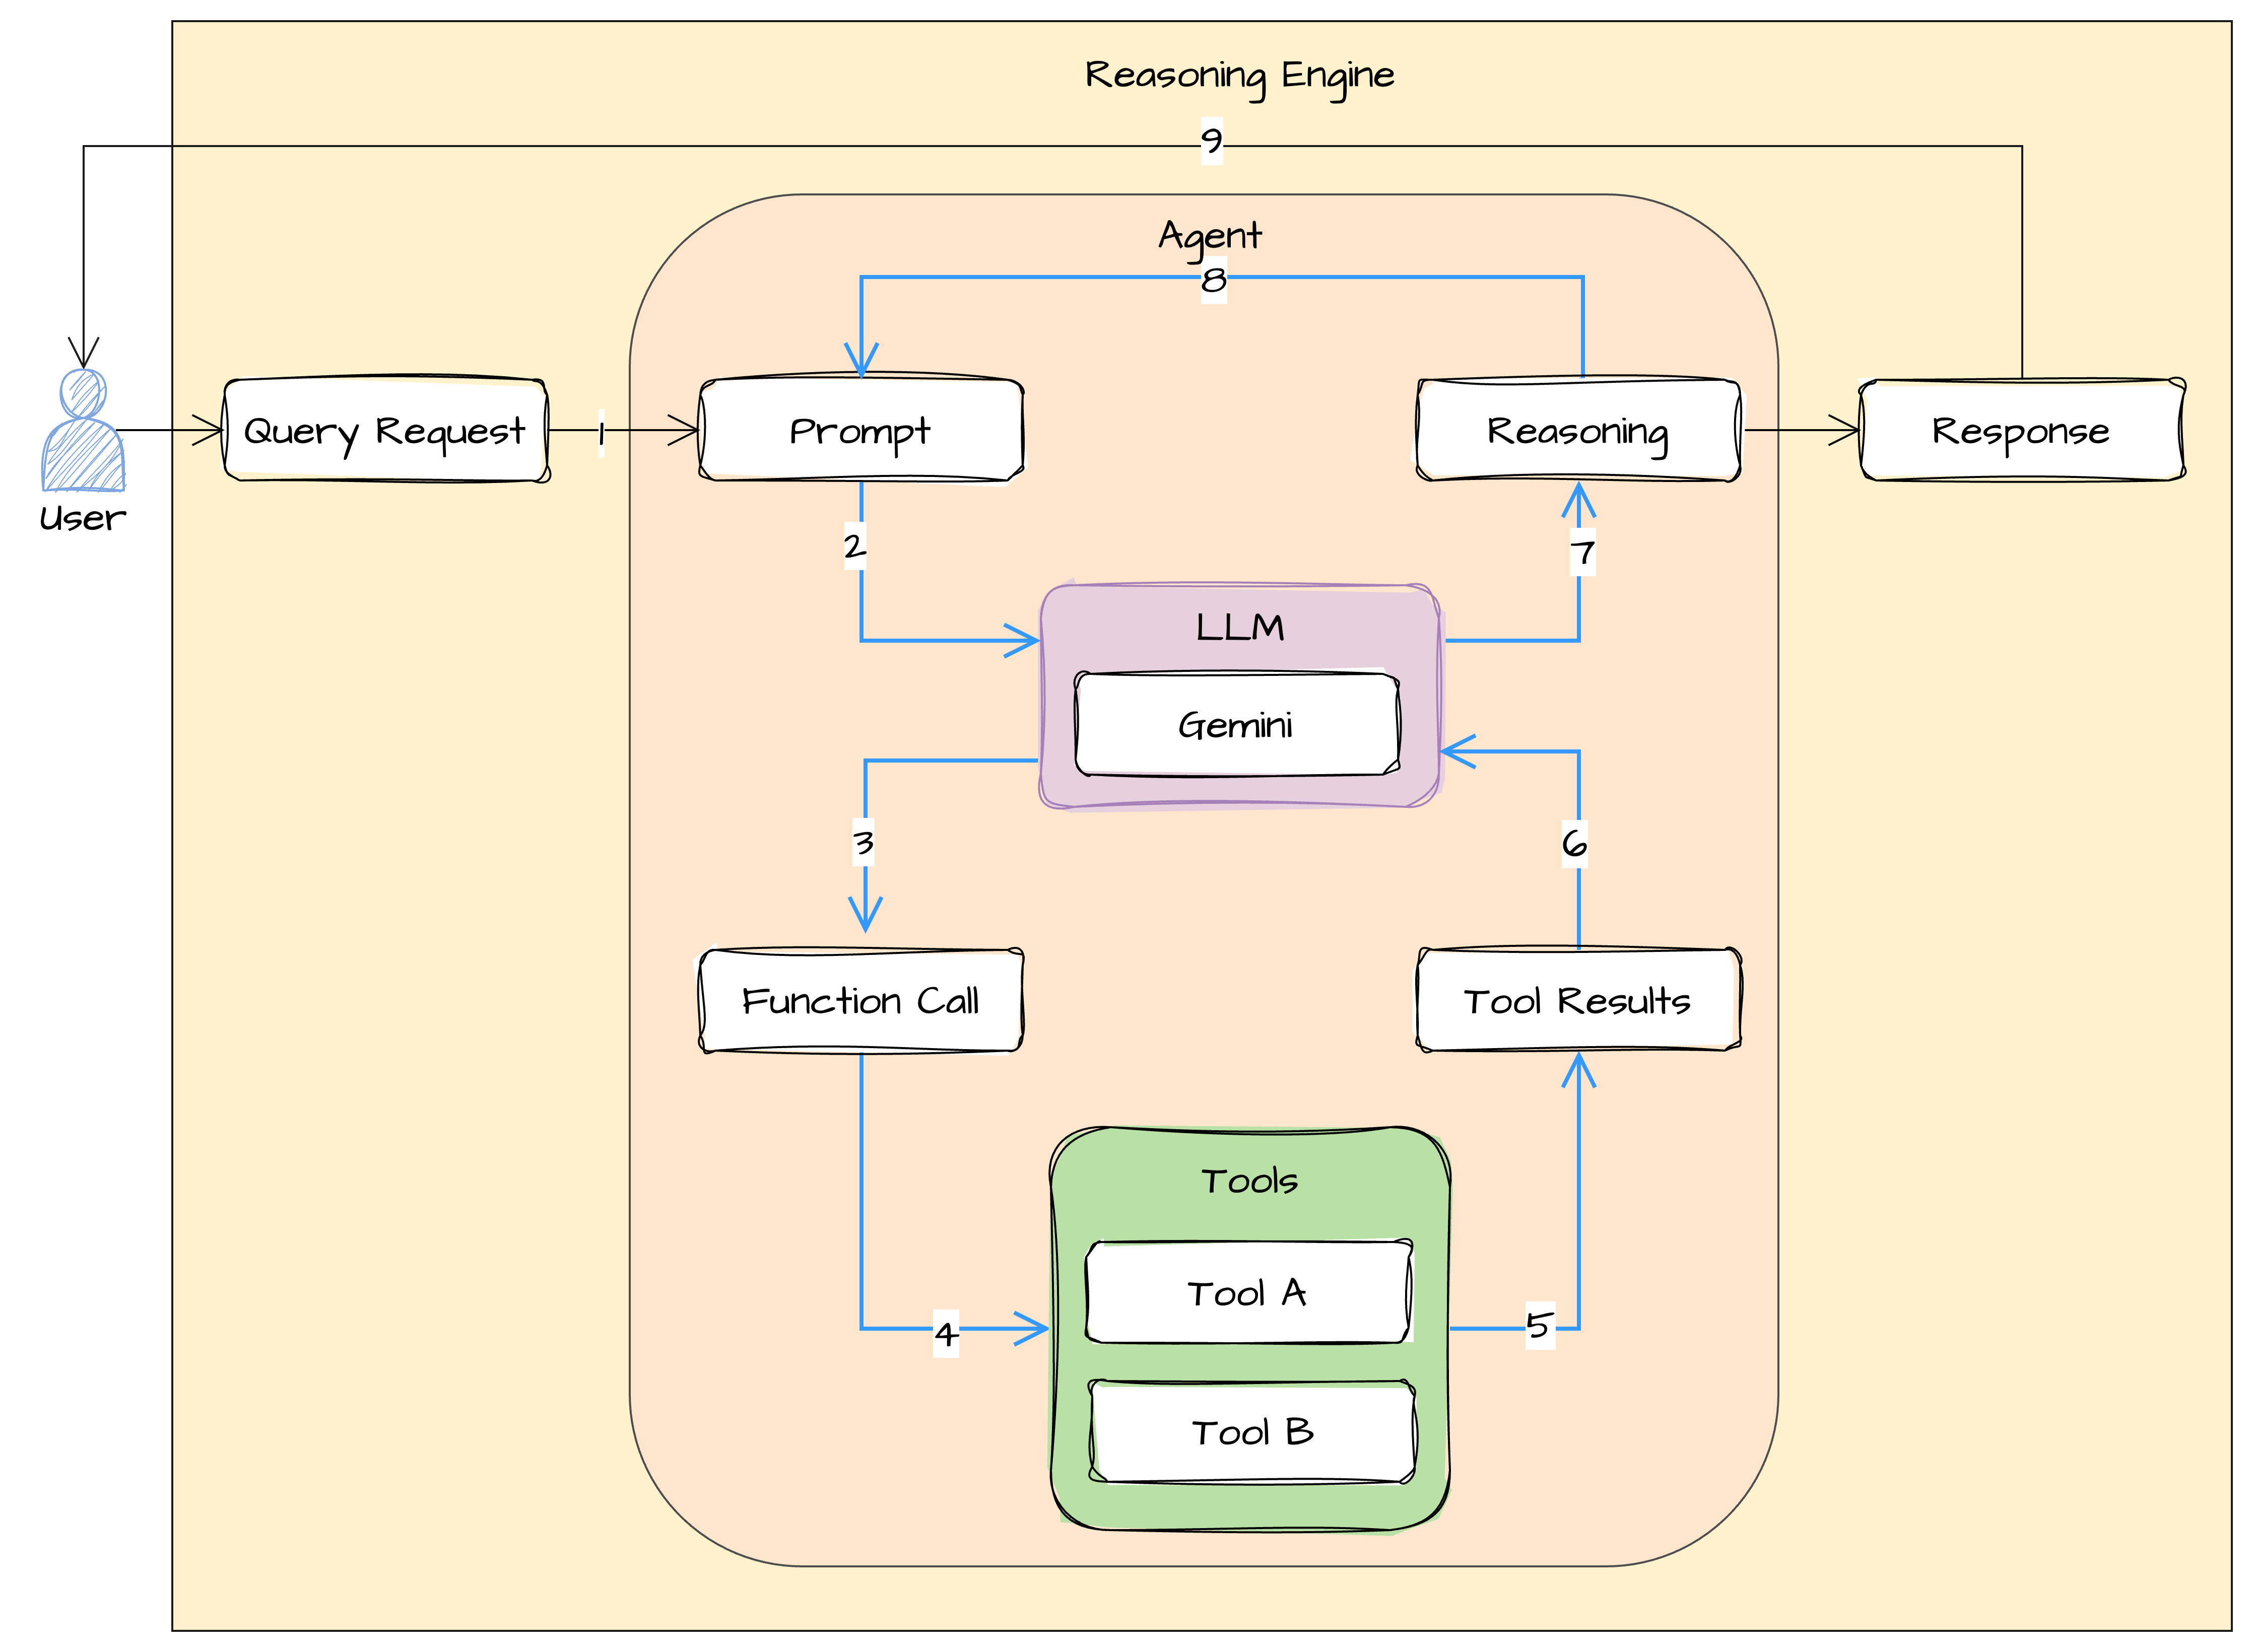

In [ ]:
response = agent.query(
    input=f"""{prompt_prefix} Generate daily sales forecasts for SKU {sku} using only last 2 weeks of sales. Display as a table with date."""
)
display(Markdown(response["output"]))

### Step 3. Define agent with custom LangChain template *[Optional]*

Define with custom LangChain template as needed to include any additional error handling, custom flows, output parsing etc. or even swap out LangChain for an entirely different orchestration framework!

In [ ]:
class CustomLangChainAgent:
    def set_up(self):
        from typing import List, Union

        import langchain_google_vertexai
        from langchain import hub
        from langchain.agents import AgentExecutor  # type: ignore
        from langchain.agents.format_scratchpad import \
            format_to_openai_function_messages
        from langchain.tools.base import StructuredTool
        from langchain_core.agents import (AgentAction, AgentActionMessageLog,
                                           AgentFinish)
        from langchain_core.output_parsers import BaseOutputParser
        from langchain_core.outputs import ChatGeneration, Generation
        from langchain_core.prompts import MessagesPlaceholder

        class _TestOutputParser(BaseOutputParser):
            def parse_result(
                self, result: List[Generation], *, partial: bool = False
            ) -> Union[AgentAction, AgentFinish]:
                if not isinstance(result[0], ChatGeneration):
                    raise ValueError(
                        "This output parser only works on ChatGeneration output"
                    )
                message = result[0].message
                function_call = message.additional_kwargs.get("function_call", {})
                if function_call:
                    function_name = function_call["name"]
                    tool_input = function_call.get("arguments", {})
                    tool_input = json.loads(tool_input)

                    content_msg = (
                        f"responded: {message.content}\n" if message.content else "\n"
                    )
                    log_msg = f"\nInvoking: `{function_name}` with `{tool_input}`\n{content_msg}\n"
                    return AgentActionMessageLog(
                        tool=function_name,
                        tool_input=tool_input,
                        log=log_msg,
                        message_log=[message],
                    )

                return AgentFinish(
                    return_values={"output": message.content}, log=str(message.content)
                )

            def parse(self, text: str) -> Union[AgentAction, AgentFinish]:
                raise ValueError("Can only parse messages")

        tools_func = [
            list_datasets,
            list_tables,
            get_table,
            run_sql_query,
            run_forecasts,
        ]

        tools = [StructuredTool.from_function(tool) for tool in tools_func]

        prompt_template = hub.pull("homanp/superagent")
        prompt = prompt_template.from_messages(
            [
                ("user", "{input}"),
                MessagesPlaceholder(variable_name="agent_scratchpad"),
            ]
        )

        llm = langchain_google_vertexai.chat_models.ChatVertexAI(
            # model_name="gemini-1.5-pro-preview-0514",
            model_name="gemini-1.0-pro-001",
            temperature=0.3,
        )

        agent = (
            {  # type: ignore
                "input": lambda x: x["input"],
                "agent_scratchpad": lambda x: format_to_openai_function_messages(
                    x["intermediate_steps"]
                ),
            }
            | prompt
            | llm.bind(functions=tools)
            | _TestOutputParser()
        )
        self.agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    def query(self, query: str):
        prompt_prefix = "REMEMBER: Current date is May 12, 2022. Use the tools provided for generating forecasts. "
        return self.agent_executor.invoke({"input": f"{prompt_prefix} {query}"})

In [ ]:
agent = CustomLangChainAgent()
agent.set_up()

In [ ]:
# sku = "JNE3797-KR-XXXL"
sku = "J0230-SKD-M"
prompt_prefix = "REMEMBER: Current date is May 12, 2022. Use tools as needed for generated forecasts after querying table."

In [ ]:
response = agent.query(
    query=f"""{prompt_prefix} Show me daily sales for SKU {sku} last 20 days by date? Display results as a table."""
)
display(Markdown(response["output"]))

In [ ]:
response = agent.query(
    query=f"""Generate daily sales forecasts for SKU {sku} based on last 2 weeks sales."""
)
display(Markdown(response["output"]))

## 🚀 04 - Deploy your agent on Vertex AI

- Let's re-define the agent to avoid any stateful information in the agent due to our testing in the previous cell

In [ ]:
model = AGENT_MODEL
agent_name = "review-product-performance"

agent = reasoning_engines.LangchainAgent(
    model=model,
    model_kwargs={"temperature": 0.3},
    tools=[list_datasets, list_tables, get_table, run_sql_query, run_forecasts],
    agent_executor_kwargs={"return_intermediate_steps": True, "verbose": True},
)

### Step 1. Set up service agent permissions

Grant required permissions to the Google-managed reasoning engine service account. Refer to the [documentation](https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/set-up#service-agent) for details.

**NOTE: You would need Project Owner or Project IAM Admin permissions to add necessary IAM policy bindings.**

In [ ]:
%%bash -s $PROJECT_ID

PROJECT_ID=$1
PROJECT_NUMBER=$(gcloud projects describe $PROJECT_ID --format="value(projectNumber)") && \
SERVICE_ACCOUNT="service-${PROJECT_NUMBER}@gcp-sa-aiplatform-re.iam.gserviceaccount.com" && \
echo $SERVICE_ACCOUNT && \
# Grant Cloud Storage permission
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member="serviceAccount:$SERVICE_ACCOUNT" \
    --role="roles/storage.admin" \
    --quiet && \
# Grant AI Platform permission.
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member="serviceAccount:$SERVICE_ACCOUNT" \
    --role="roles/aiplatform.user" \
    --quiet && \
# Grant BigQuery user and job permissions
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member="serviceAccount:$SERVICE_ACCOUNT" \
    --role="roles/bigquery.user" \
    --quiet && \
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member="serviceAccount:$SERVICE_ACCOUNT" \
    --role="roles/bigquery.dataViewer" \
    --quiet && \
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member="serviceAccount:$SERVICE_ACCOUNT" \
    --role="roles/bigquery.jobUser" \
    --quiet && \
gcloud projects get-iam-policy $PROJECT_ID \
    --filter=bindings.members:serviceAccount:$SERVICE_ACCOUNT

### Step 2. Deploy the agent to Reasoning Engine in Vertex AI

- Deploy the agent to Reasoning Engine in Vertex AI by calling `reasoning_engines.ReasoningEngine.create()` along with the instance of the agent and the Python packages that agent requires at runtime:

In [ ]:
remote_agent = reasoning_engines.ReasoningEngine.create(
    reasoning_engine=agent,
    reasoning_engine_name=agent_name,
    display_name=agent_name,
    requirements=[
        "google-cloud-aiplatform==1.51.0",
        "google-cloud-bigquery==3.22.0",
        "langchain==0.1.20",
        "langchain-google-vertexai==1.0.3",
        "cloudpickle==3.0.0",
        "pydantic==2.7.1",
    ],
)

In [ ]:
engines = [
    engine.resource_name
    for engine in reasoning_engines.ReasoningEngine.list(
        filter=f'display_name="{agent_name}"'
    )
]

if len(engines) > 0:
    engine_id = engines[0]
else:
    raise Exception("Reasoning engine agent with that name does not exist")

In [ ]:
engines = [
    engine.resource_name
    for engine in reasoning_engines.ReasoningEngine.list(
        filter=f'display_name="{agent_name}"'
    )
]

### Step 2. Test remote agent

In [ ]:
remote_agent = reasoning_engines.ReasoningEngine(engine_id)

In [ ]:
# sku = "JNE3797-KR-XXXL"
sku = "J0230-SKD-M"
prompt_prefix = "REMEMBER: Current date is May 12, 2022. Use tools as needed to generate forecasts after querying the relevant tables."

In [ ]:
response = remote_agent.query(
    input=f"""Which tables can you query from {BQ_DATASET_ID} dataset?"""
)
print(response["output"])

In [ ]:
response = remote_agent.query(
    input=f"""{prompt_prefix} What are daily sales for SKU {sku} in last 2 weeks with date? Display as a table with date."""
)
display(Markdown(response["output"]))

In [ ]:
response = remote_agent.query(
    input=f"""{prompt_prefix} Generate daily sales forecasts for SKU {sku} using only last 2 weeks of sales. Display as a table with date."""
)
display(Markdown(response["output"]))

---

## 🧹 Cleaning up

Clean up resources created in this notebook.

In [ ]:
delete_agent = True
delete_endpoint = True
delete_bq_dataset = True
delete_bucket = True

- 🗑️ Remove reasoning engine agents deployed

In [ ]:
if delete_agent:
    # list engines and filter
    engines = [
        engine.resource_name
        for engine in reasoning_engines.ReasoningEngine.list(
            filter=f'display_name="{agent_name}"'
        )
    ]
    if len(engines) > 0:
        engine_id = engines[0]
        agent = reasoning_engines.ReasoningEngine(engine_id)
        print(f"Deleting agent {agent.display_name}")
        agent.delete()
    else:
        raise Exception(
            f"Reasoning engine agent with name `{agent_name}` does not exist"
        )

- 🗑️ Remove Vertex AI prediction endpoint deployed with TimesFM model

In [ ]:
if delete_endpoint:
    endpoints = aiplatform.Endpoint.list(
        filter=f'display_name="{TIMESFM_ENDPOINT_DISPLAY_NAME}"'
    )

    if len(endpoints) > 0:
        # Undeploy model and delete endpoint.
        endpoint = aiplatform.Endpoint(endpoints[0].resource_name)
        deployed_models = [
            aiplatform.Model(model.model) for model in endpoint.list_models()
        ]
        print(f"Deleting endpoint {endpoint.display_name}")
        endpoint.delete(force=True)
        # Delete models
        [model.delete() for model in deployed_models]
    else:
        raise Exception(
            f"Endpoint with name {TIMESFM_ENDPOINT_DISPLAY_NAME} does not exist"
        )

- 🗑️ Remove BigQuery tables and datasets

In [ ]:
if delete_bq_dataset:
    print(f"Deleting BigQuery dataset with id {BQ_DATASET_ID}")
    ! bq rm -r -f $BQ_DATASET_ID
    ! bq ls

- 🗑️ Remove Google Cloud Storage bucket

In [ ]:
if delete_bucket:
    print(f"Deleting contents from the Cloud Storage bucket {STAGING_BUCKET_URI}")
    # uncomment below line to delete contents of the bucket
    # ! gsutil -m rm -r $STAGING_BUCKET_URI

---